In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Auto-detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
def my_layer_norm(feat):
    mean = feat.mean((2, 3), keepdim=True)
    std = feat.std((2, 3), keepdim=True) + 1e-9
    feat = 2 * (feat - mean) / std - 1
    feat = 5 * feat
    return feat

class AOTBlock(nn.Module):
    def __init__(self, dim, rates):
        super(AOTBlock, self).__init__()
        self.rates = rates
        for i, rate in enumerate(rates):
            setattr(self, f"block_{str(i).zfill(2)}", nn.Sequential(
                nn.ReflectionPad2d(rate),
                nn.Conv2d(dim, dim // 4, 3, padding=0, dilation=rate),
                nn.ReLU(inplace=True)
            ))
        self.fuse = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, padding=0)
        )
        self.gate = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, padding=0)
        )

    def forward(self, x):
        out = [getattr(self, f"block_{str(i).zfill(2)}")(x) for i in range(len(self.rates))]
        out = torch.cat(out, dim=1)
        out = self.fuse(out)
        mask = torch.sigmoid(my_layer_norm(self.gate(x)))
        return x * (1 - mask) + out * mask

In [10]:
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, scale=2):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=scale, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, 3, padding=0),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)

In [3]:
class AOTGenerator(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super(AOTGenerator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # AOT Blocks
        self.middle = nn.Sequential(
            AOTBlock(256, rates=[1, 2, 4, 8]),
            AOTBlock(256, rates=[1, 2, 4, 8])
        )

        # Decoder
        self.decoder = nn.Sequential(
            UpConv(256, 128),
            UpConv(128, 64),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [4]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
import numpy as np
import random
from PIL import Image, ImageDraw

def generate_random_mask(img_size=(256, 256), num_rects=5, max_rect_size=(50, 50)):
    mask = Image.new("L", img_size, 0)
    draw = ImageDraw.Draw(mask)
    
    for _ in range(num_rects):
        max_width, max_height = max_rect_size

        x1 = random.randint(0, img_size[0] - max_width)
        y1 = random.randint(0, img_size[1] - max_height)
        rect_width = random.randint(10, max_width)  # min size = 10
        rect_height = random.randint(10, max_height)

        x2 = x1 + rect_width
        y2 = y1 + rect_height

        draw.rectangle([x1, y1, x2, y2], fill=255)
    
    return mask

In [6]:
from torch.utils.data import Dataset
class InpaintingDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_list = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        image = Image.open(img_path).convert("RGB").resize((256, 256))

        # Generate mask
        mask = generate_random_mask((256, 256))
        
        if self.transform:
            image = self.transform(image)
            mask_tensor = self.transform(mask)
        else:
            image = transforms.ToTensor()(image)
            mask_tensor = transforms.ToTensor()(mask)

        masked_image = image * (1 - mask_tensor)
        input_tensor = torch.cat([masked_image, mask_tensor], dim=0)

        return input_tensor, image, mask_tensor

In [11]:
generator = AOTGenerator().to(device)

In [12]:
discriminator = PatchDiscriminator().to(device)

In [14]:
generator.load_state_dict(torch.load('/kaggle/input/models/generator_epoch_100.pth'))

/tmp/ipykernel_31/781934848.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/kaggle/input/models/generator_epoch_100.pth'))


<All keys matched successfully>

In [15]:
discriminator.load_state_dict(torch.load('/kaggle/input/models/discriminator_epoch_100.pth'))

/tmp/ipykernel_31/33672114.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discriminator.load_state_dict(torch.load('/kaggle/input/models/discriminator_epoch_100.pth'))


<All keys matched successfully>

In [17]:
import os
import torch
from PIL import Image
from torchvision import transforms
from tqdm import tqdm


input_dir = "/kaggle/input/pothole-and-plain-rode-images/My Dataset/test/Plain"
output_dir = "/kaggle/working/inpainted_frames1"
os.makedirs(output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


# Mask generator (same as before)
def generate_random_mask(img_size=(256, 256), num_rects=5, max_rect_size=(50, 50)):
    mask = Image.new("L", img_size, 0)
    draw = ImageDraw.Draw(mask)
    for _ in range(num_rects):
        max_width, max_height = max_rect_size
        x1 = torch.randint(0, img_size[0] - max_width, (1,)).item()
        y1 = torch.randint(0, img_size[1] - max_height, (1,)).item()
        w = torch.randint(10, max_width, (1,)).item()
        h = torch.randint(10, max_height, (1,)).item()
        draw.rectangle([x1, y1, x1 + w, y1 + h], fill=255)
    return mask

image_list = sorted(os.listdir(input_dir))
for img_name in tqdm(image_list, desc="Inpainting"):
    img_path = os.path.join(input_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    mask = generate_random_mask()

    image_tensor = transform(image).to(device)
    mask_tensor = transform(mask).to(device)
    masked_image = image_tensor * (1 - mask_tensor)

    input_tensor = torch.cat([masked_image, mask_tensor], dim=0).unsqueeze(0)
    with torch.no_grad():
        output = generator(input_tensor)[0].cpu()

    # Save output
    output_img = transforms.ToPILImage()(output.clamp(-1, 1) * 0.5 + 0.5)  # Rescale [-1, 1] to [0, 1]
    output_img.save(os.path.join(output_dir, img_name))

Inpainting: 100%|██████████| 8/8 [00:00<00:00,  9.07it/s]


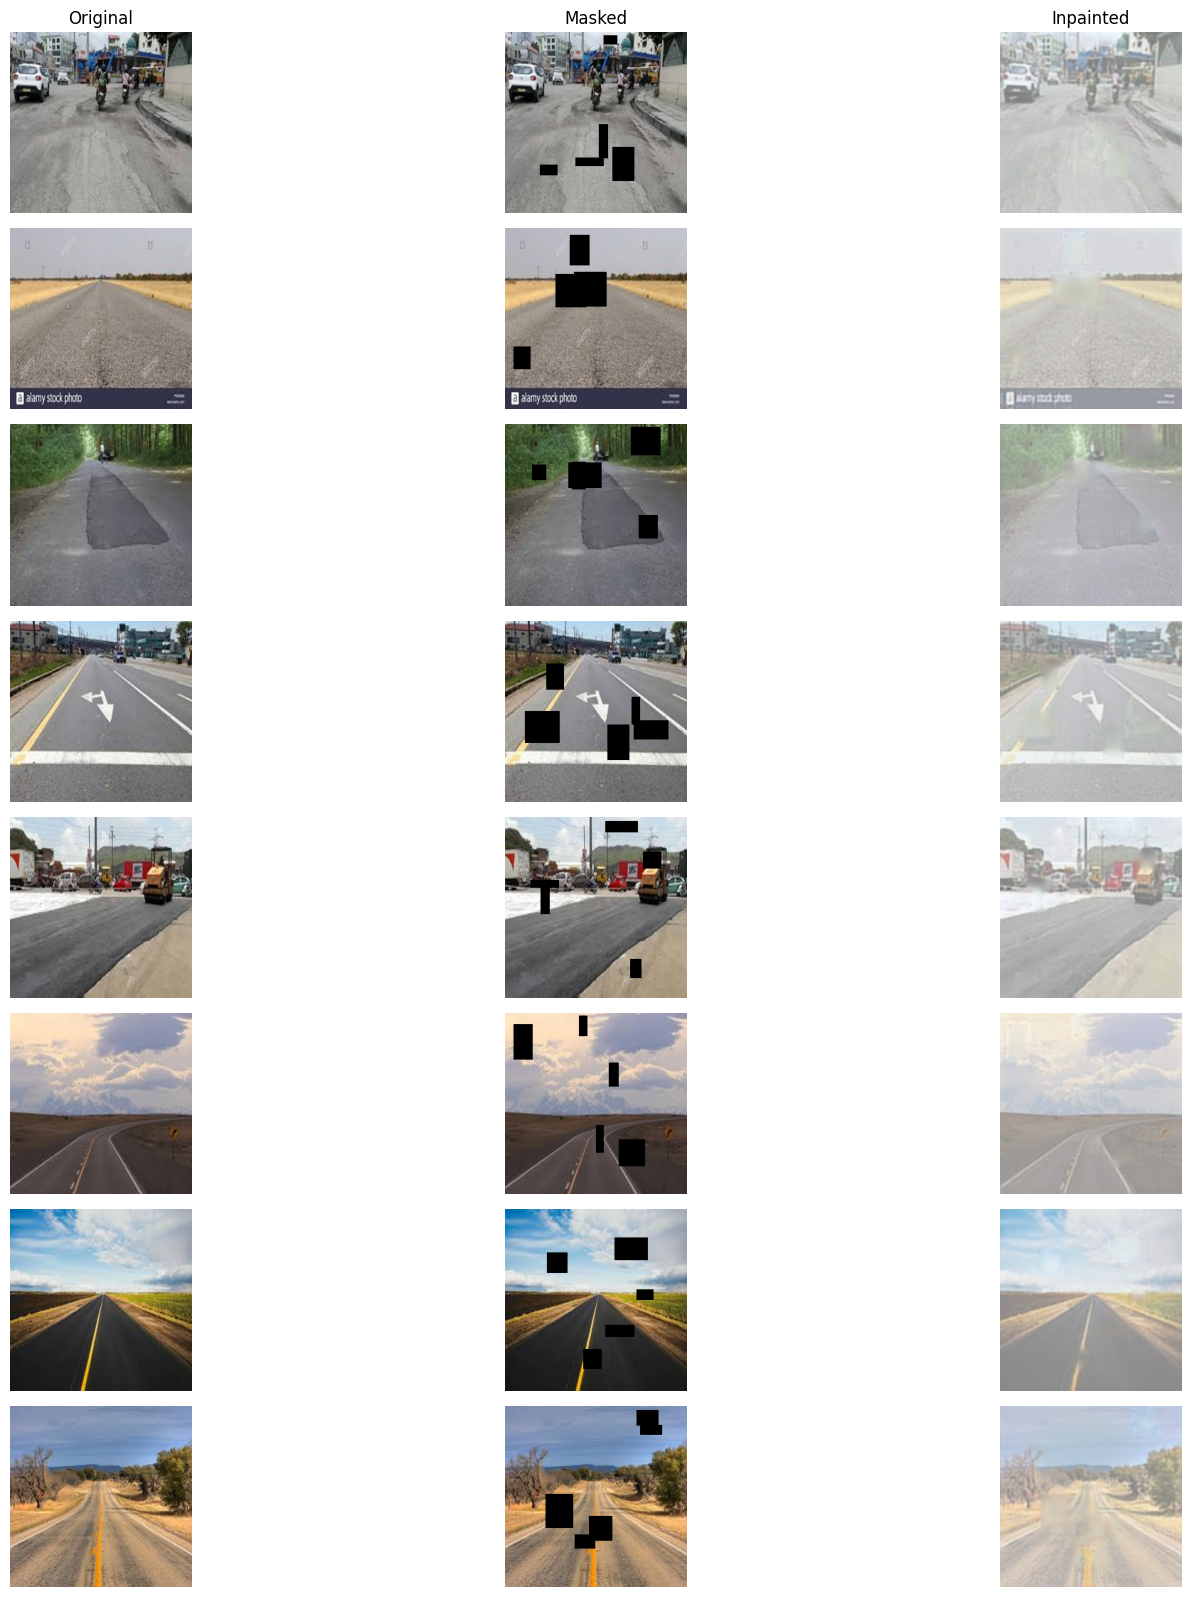

In [18]:
import matplotlib.pyplot as plt
import numpy as np


num_images = 10
sample_images = image_list[:num_images]

plt.figure(figsize=(15, num_images * 2))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(input_dir, img_name)
    image = Image.open(img_path).convert("RGB").resize((256, 256))
    mask = generate_random_mask()

    image_tensor = transform(image).to(device)
    mask_tensor = transform(mask).to(device)
    masked_image = image_tensor * (1 - mask_tensor)

    input_tensor = torch.cat([masked_image, mask_tensor], dim=0).unsqueeze(0)

    # Inference
    with torch.no_grad():
        output = generator(input_tensor)[0].cpu()

    # Convert tensors to displayable images
    original_np = image_tensor.cpu().permute(1, 2, 0).numpy()
    masked_np = masked_image.cpu().permute(1, 2, 0).numpy()
    output_np = ((output.permute(1, 2, 0).numpy() + 1) / 2).clip(0, 1)

    # Plot
    for j, img in enumerate([original_np, masked_np, output_np]):
        ax = plt.subplot(num_images, 3, i * 3 + j + 1)
        ax.imshow(img)
        ax.axis("off")
        if i == 0:
            ax.set_title(["Original", "Masked", "Inpainted"][j])

plt.tight_layout()
plt.show()

In [19]:
import os
import torch
from PIL import Image
from torchvision import transforms
from tqdm import tqdm


input_dir = "/kaggle/input/pothole-and-plain-rode-images/My Dataset/test/Pothole"
output_dir = "/kaggle/working/inpainted_frames1"
os.makedirs(output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


# Mask generator (same as before)
def generate_random_mask(img_size=(256, 256), num_rects=5, max_rect_size=(50, 50)):
    mask = Image.new("L", img_size, 0)
    draw = ImageDraw.Draw(mask)
    for _ in range(num_rects):
        max_width, max_height = max_rect_size
        x1 = torch.randint(0, img_size[0] - max_width, (1,)).item()
        y1 = torch.randint(0, img_size[1] - max_height, (1,)).item()
        w = torch.randint(10, max_width, (1,)).item()
        h = torch.randint(10, max_height, (1,)).item()
        draw.rectangle([x1, y1, x1 + w, y1 + h], fill=255)
    return mask

image_list = sorted(os.listdir(input_dir))
for img_name in tqdm(image_list, desc="Inpainting"):
    img_path = os.path.join(input_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    mask = generate_random_mask()

    image_tensor = transform(image).to(device)
    mask_tensor = transform(mask).to(device)
    masked_image = image_tensor * (1 - mask_tensor)

    input_tensor = torch.cat([masked_image, mask_tensor], dim=0).unsqueeze(0)
    with torch.no_grad():
        output = generator(input_tensor)[0].cpu()

    # Save output
    output_img = transforms.ToPILImage()(output.clamp(-1, 1) * 0.5 + 0.5)  # Rescale [-1, 1] to [0, 1]
    output_img.save(os.path.join(output_dir, img_name))

Inpainting: 100%|██████████| 8/8 [00:00<00:00, 31.96it/s]


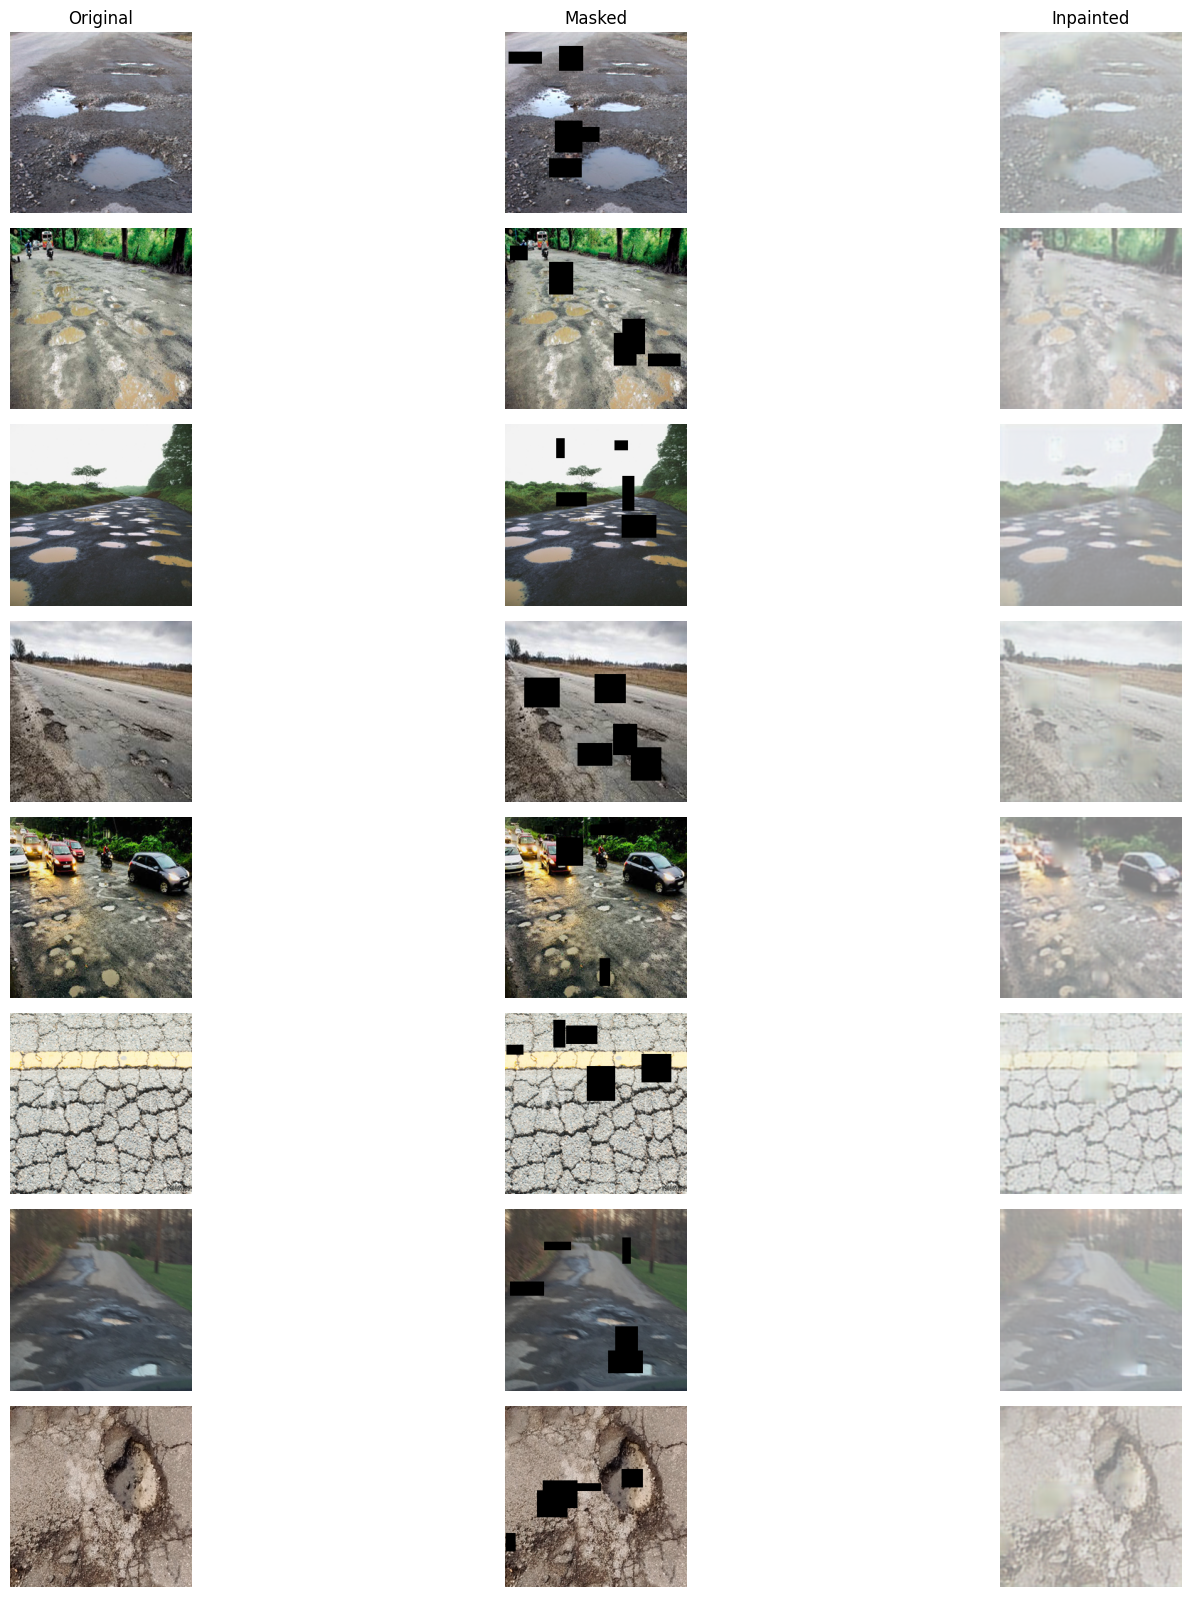

In [20]:
import matplotlib.pyplot as plt
import numpy as np


num_images = 10
sample_images = image_list[:num_images]

plt.figure(figsize=(15, num_images * 2))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(input_dir, img_name)
    image = Image.open(img_path).convert("RGB").resize((256, 256))
    mask = generate_random_mask()

    image_tensor = transform(image).to(device)
    mask_tensor = transform(mask).to(device)
    masked_image = image_tensor * (1 - mask_tensor)

    input_tensor = torch.cat([masked_image, mask_tensor], dim=0).unsqueeze(0)

    # Inference
    with torch.no_grad():
        output = generator(input_tensor)[0].cpu()

    # Convert tensors to displayable images
    original_np = image_tensor.cpu().permute(1, 2, 0).numpy()
    masked_np = masked_image.cpu().permute(1, 2, 0).numpy()
    output_np = ((output.permute(1, 2, 0).numpy() + 1) / 2).clip(0, 1)

    # Plot
    for j, img in enumerate([original_np, masked_np, output_np]):
        ax = plt.subplot(num_images, 3, i * 3 + j + 1)
        ax.imshow(img)
        ax.axis("off")
        if i == 0:
            ax.set_title(["Original", "Masked", "Inpainted"][j])

plt.tight_layout()
plt.show()